In [1]:
import drjit as dr
import mitsuba as mi
import numpy as np
import warnings
import re

mi.set_variant('cuda_ad_rgb')

In [2]:
def create_subset_scene_params(params: mi.SceneParameters, pattern: re.Pattern):
    return {k: mi.Color3f(v) for k, v in params.items() if pattern.search(k)}

def randomize_srgb_params(params: mi.SceneParameters, ref_params: dict, bound: float):
    if bound < 0.0:
        warnings.warn(f'Negative bound value! Using 1.0 as the bound value.')
        bound = 1.0
        
    num_of_channels = 3
    rng = mi.PCG32(size=num_of_channels * len(ref_params))
    samples = rng.next_float64() * bound
    
    for i, key in enumerate(ref_params):
        if type(params[key]) is not mi.Color3f:
            warn_msg = 'Invalid type:' + str(type(params[key]))
            warnings.warn(warn_msg)
            raise ValueError('Given ref_params dictionary values must have the mi.Color3f type!')
        params[key] = mi.Color3f(
            samples[i*num_of_channels], samples[i*num_of_channels+1], samples[i*num_of_channels+2])

    params.update();

In [3]:
scene = mi.load_file('../scenes/cbox-sch-modified/cbox-multiple-lights-2.xml', res=256, integrator='prb')
params = mi.traverse(scene)

In [4]:
radiance_pattern = re.compile(r'.*\.radiance\.value')
ref_radiance_params = create_subset_scene_params(params, radiance_pattern)

In [5]:
reflectance_pattern = re.compile(r'.*\.reflectance\.value')
ref_reflectance_params = create_subset_scene_params(params, reflectance_pattern)

In [6]:
ref_params = dict(ref_radiance_params)
ref_params.update(ref_reflectance_params)

In [7]:
image_ref = mi.render(scene, spp=512)

# Preview the reference image
mi.util.convert_to_bitmap(image_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [512, 512],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [8]:
randomize_srgb_params(params, ref_radiance_params, 500.0)
randomize_srgb_params(params, ref_reflectance_params, 1.0)

In [9]:
modified_params = dict(ref_radiance_params)
modified_params.update(ref_reflectance_params)
for key in modified_params:
    print('modified:', params[key])
    print('ref:', modified_params[key])

modified: [[54.189353942871094, 79.20679473876953, 486.7416687011719]]
ref: [[10.0, 7.2732648849487305, 4.3814592361450195]]
modified: [[3.4222607612609863, 28.73792266845703, 287.5155334472656]]
ref: [[72.29999542236328, 72.29999542236328, 72.29999542236328]]
modified: [[435.9079284667969, 367.6947937011719, 391.4736022949219]]
ref: [[72.29999542236328, 72.29999542236328, 72.29999542236328]]
modified: [[248.9824981689453, 41.236080169677734, 23.194456100463867]]
ref: [[72.29999542236328, 72.29999542236328, 72.29999542236328]]
modified: [[407.9986267089844, 431.2792053222656, 466.9787902832031]]
ref: [[72.29999542236328, 72.29999542236328, 72.29999542236328]]
modified: [[0.10837870836257935, 0.1584135890007019, 0.9734833240509033]]
ref: [[0.0, 0.0, 0.0]]
modified: [[0.006844521500170231, 0.057475846260786057, 0.575031042098999]]
ref: [[0.09101100265979767, 0.800000011920929, 0.04435800015926361]]
modified: [[0.8718158602714539, 0.7353895902633667, 0.7829472422599792]]
ref: [[0.80000001

In [10]:
radiance_opt = mi.ad.Adam(lr=100.0, params={k: params[k] for k in ref_radiance_params})
params.update(radiance_opt);

In [11]:
# reflactence optimizer
reflectance_opt = mi.ad.Adam(lr=1.0, params={k: params[k] for k in ref_reflectance_params})
params.update(reflectance_opt);

In [12]:
img_init = mi.render(scene, spp=256) # seed = 0 missing
mi.util.convert_to_bitmap(img_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [512, 512],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [13]:
iteration_count = 100
minError = 0.01

In [14]:
param_errors = {k: [dr.sum(dr.sqr(ref_params[key] - params[key]))[0]] for k in modified_params}

# set initial param errors
# param_errors = {}
# for key in modified_params:
#     param_errors[key] = dr.sum(dr.sqr(ref_params[key] - params[key]))[0]

In [15]:
opts = [radiance_opt, reflectance_opt]

In [16]:
from contextlib import redirect_stdout

with open('out.txt', 'w') as f:
    with redirect_stdout(f):
        for it in range(iteration_count):

            # check all optimization parameters and if defined threshold is 
            # achieved stop optimization for that parameter (i.e. pop optimization param)
            for opt in opts:
                for key in list(opt.keys()):
                    if param_errors[key][-1] < minError and key in opt:
                        opt.variables.pop(key)
                        print(f'Key {key} is optimized')

            # stop optimization if all optimization variables are empty 
            # (i.e. if all optimization params reached a defined threshold)
            if all(map(lambda opt: not opt.variables, opts)):
                break

            # Perform a (noisy) differentiable rendering of the scene
            image = mi.render(scene, params, seed=it, spp=4)

            # Evaluate the objective function from the current rendered image
            loss = dr.sum(dr.sqr(image - image_ref)) / len(image)

            # Backpropagate through the rendering process
            dr.backward(loss)

            for opt in opts:
                # Optimizer: take a gradient descent step
                opt.step()
                for key in opt.keys():
                    # Post-process the optimized parameters to ensure legal 
                    # radiance values
                    if reflectance_pattern.search(key):
                        opt[key] = dr.clamp(reflectance_opt[key], 0.0, 1.0)
                # Update the scene state to the new optimized values
                params.update(opt)

            # update errors that are being optimized
            print(f"Iteration {it:02d}")
            for key in modified_params.keys():
                err = dr.sum(dr.sqr(ref_params[key] - params[key]))[0]
                param_errors[key].append(err)
                print(f"\tkey= {key} error= {param_errors[key][-1]:6f}")


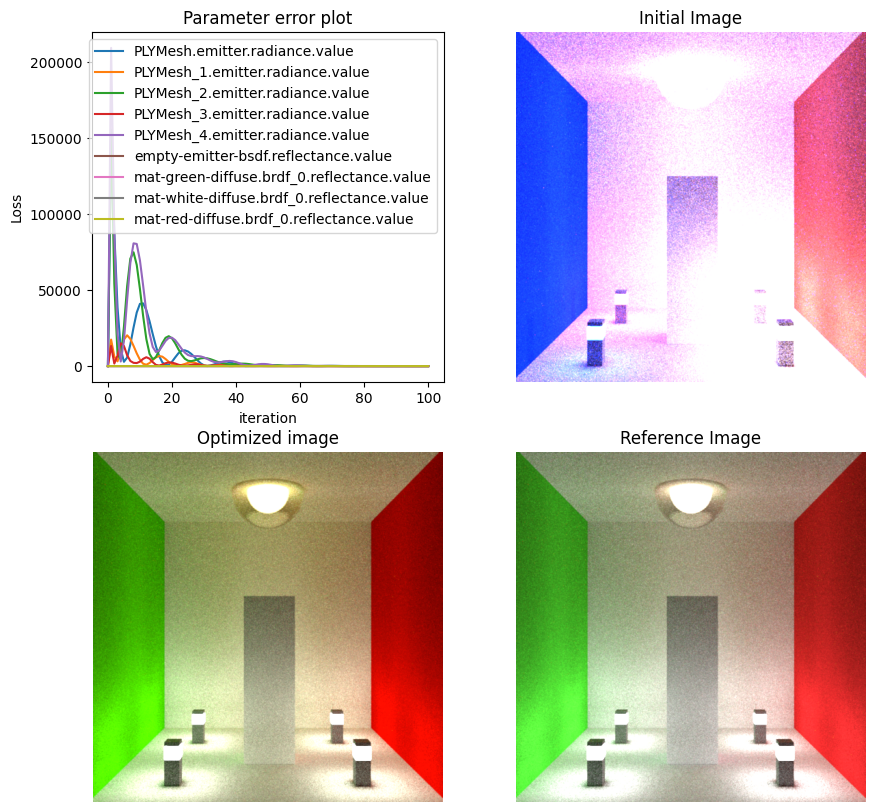

In [18]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for k, v in param_errors.items():
    axs[0][0].plot(v, label=k)

axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].legend()
axs[0][0].set_title('Parameter error plot');

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=512)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

axs[1][1].imshow(mi.util.convert_to_bitmap(image_ref))
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');